In [39]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AddChanneld,
    AsDiscrete,
    AsDiscreted,
    Compose,
    EnsureChannelFirstd,
    EnsureTyped,
    EnsureType,
    Invertd,
    LoadImaged,
    RandFlipd,
    RandSpatialCropd,
    RandZoomd,
    Resized,
    ScaleIntensityRanged,
    SpatialCrop,
    SpatialCropd,
    ToTensord,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import monai.utils as utils

import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
from glob import glob

import itk
from itk import TubeTK as ttk

import numpy as np

import site
site.addsitedir('../../ARGUS')
from ARGUSUtils_Transforms import *

In [42]:
img1_dir = "../../Data/VFoldData/ROIData/"
    
all_images = sorted(glob(os.path.join(img1_dir, '*Class[NS]*.roi.nii.gz')))
all_labels = sorted(glob(os.path.join(img1_dir, '*Class[NS]*.roi.extruded-overlay-NS.nii.gz')))

gpu_device = 0

num_classes = 3

net_in_dim = 3
net_in_channels = 1
net_channels=(24, 32, 64, 128)
net_strides=(2, 2, 2)
        
num_folds = 15

num_slices = 48
size_x = 128
size_y = 224

roi_size = (size_x,size_y,num_slices)

num_workers_te = 0
batch_size_te = 1

model_filename_base = "./results/BAMC_PTX_ROI_3DUNet-Extruded-S.best_model.vfold"

num_images = len(all_images)
print(num_images, len(all_labels))

ns_prefix = ['025ns','026ns','027ns','035ns','048ns','055ns','117ns',
             '135ns','193ns','210ns','215ns','218ns','219ns','221ns','247ns']
s_prefix = ['004s','019s','030s','034s','037s','043s','065s','081s',
            '206s','208s','211s','212s','224s','228s','236s','237s']

fold_prefix_list = []
ns_count = 0
s_count = 0
for i in range(num_folds):
    if i%2 == 0:
        num_ns = 1
        num_s = 1
        if i > num_folds-3:
            num_s = 2
    else:
        num_ns = 1
        num_s = 1
    f = []
    for ns in range(num_ns):
        f.append([ns_prefix[ns_count+ns]])
    ns_count += num_ns
    for s in range(num_s):
        f.append([s_prefix[s_count+s]])
    s_count += num_s
    fold_prefix_list.append(f)
        
train_files = []
val_files = []
test_files = []
for i in range(num_folds):
    tr_folds = []
    for f in range(i,i+num_folds-2):
        tr_folds.append(fold_prefix_list[f%num_folds])
    tr_folds = list(np.concatenate(tr_folds).flat)
    va_folds = list(np.concatenate(fold_prefix_list[(i+num_folds-2) % num_folds]).flat)
    te_folds = list(np.concatenate(fold_prefix_list[(i+num_folds-1) % num_folds]).flat)
    train_files.append(
            [
                {"image": img, "label": seg}
                for img, seg in zip(
                    [im for im in all_images if any(pref in im for pref in tr_folds)],
                    [se for se in all_labels if any(pref in se for pref in tr_folds)])
            ]
        )
    val_files.append(
            [
                {"image": img, "label": seg}
                for img, seg in zip(
                    [im for im in all_images if any(pref in im for pref in va_folds)],
                    [se for se in all_labels if any(pref in se for pref in va_folds)])
            ]
        )
    test_files.append(
            [
                {"image": img, "label": seg}
                for img, seg in zip(
                    [im for im in all_images if any(pref in im for pref in te_folds)],
                    [se for se in all_labels if any(pref in se for pref in te_folds)])
            ]
        )
    print(len(train_files[i]),len(val_files[i]),len(test_files[i]))

110 110
96 6 8
92 8 10
93 10 7
97 7 6
96 6 8
98 8 4
100 4 6
97 6 7
98 7 5
92 5 13
92 13 5
98 5 7
93 7 10
92 10 8
96 8 6


In [43]:
train_shape = itk.GetArrayFromImage(itk.imread(train_files[0][0]["image"])).shape

test_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image", "label"]),
        ScaleIntensityRanged(keys=["image"],
            a_min=0, a_max=255,
            b_min=0.0, b_max=1.0),
        ToTensord(keys=["image", "label"]),
    ]
)

In [44]:
test_ds = [Dataset(data=test_files[i], transform=test_transforms)
          for i in range(num_folds)]
test_loader = [DataLoader(test_ds[i], batch_size=batch_size_te, num_workers=num_workers_te)
              for i in range(num_folds)]

In [45]:
batchnum = 2
imgnum = 0
lbl = utils.first(test_loader[batchnum])["label"]
m = lbl[imgnum,0,:,:,24].max()
print(m)
if m == 1:
    img = utils.first(test_loader[0])["image"]
    plt.subplots()
    plt.imshow(img[imgnum,0,:,:,24])
    plt.subplots()
    plt.imshow(lbl[imgnum,0,:,:,24])
print("Data Size =", lbl.shape)

tensor(2.)
Data Size = torch.Size([1, 1, 128, 224, 61])


In [46]:
# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda:"+str(gpu_device))

In [47]:
def plot_vfold_training_curves(vfold_num, test_loader, min_size_comp, min_portion_comp, p_prior, graph):
    if graph:
        print("   VFOLD =", vfold_num, "of", num_folds)
    
    correct = 0
    incorrect = 0
    
    slice_correct = 0
    slice_incorrect = 0
    
    false_negatives = 0
    slice_false_negatives = 0
    
    loss_file = model_filename_base+"_loss_"+str(vfold_num)+".npy"
    if os.path.exists(loss_file):
        epoch_loss_values = np.load(loss_file)
    
        metric_file = model_filename_base+"_val_dice_"+str(vfold_num)+".npy"
        metric_values = np.load(metric_file)
    
        if graph:
            plt.figure("train", (12, 6))
            plt.subplot(1, 2, 1)
            plt.title("Epoch Average Loss")
            x = [i + 1 for i in range(len(epoch_loss_values))]
            y = epoch_loss_values
            plt.xlabel("epoch")
            plt.plot(x, y)
            plt.ylim([0.2,0.8])
            plt.subplot(1, 2, 2)
            plt.title("Val Mean Dice")
            x = [2 * (i + 1) for i in range(len(metric_values))]
            y = metric_values
            plt.xlabel("epoch")
            plt.plot(x, y)
            plt.ylim([0.2,0.8])
            plt.show()
    
    model_file = model_filename_base+'_'+str(vfold_num)+'.pth'
    if os.path.exists(model_file):
        model = UNet(
            dimensions=net_in_dim,
            in_channels=net_in_channels,
            out_channels=num_classes,
            channels=net_channels,
            strides=net_strides,
            num_res_units=2,
            norm=Norm.BATCH,
        ).to(device)    
        model.load_state_dict(torch.load(model_file))
        model.eval()
        with torch.no_grad():
            i = 0
            fname = os.path.basename(test_files[vfold_num][i]["image"])
            prevfname = fname
            count1 = 0
            count = 0
            for b,test_data in enumerate(test_loader):
                test_outputs = sliding_window_inference(
                    test_data["image"].to(device), roi_size, batch_size_te, model
                )
                for j in range(test_outputs.shape[0]):
                    prevfname = fname
                    fname = os.path.basename(test_files[vfold_num][i]["image"])
                    
                    if fname[:22]!=prevfname[:22]:
                        #print("  ", prevfname[:22], "Count of slidings =", count1, "of", count)
                        if count1 == count:
                            if graph:
                                print("  Winner = Sliding")
                            if prevfname[3] == 's':
                                correct += 1
                            else:
                                incorrect += 1
                                false_negatives += 1
                                print(" FN Patient =", prevfname)
                        else:
                            if graph:
                                print("  Winner = Not Sliding")
                            if prevfname[3] == 'n':
                                correct += 1
                            else:
                                incorrect += 1
                                print(" FP Patient =", prevfname)
                        if graph:
                            print()
                            print()
                        count1 = 0
                        count = 0
                    
                    prob_shape = test_outputs[j,:,:,:,:].shape
                    prob = np.empty(prob_shape)
                    for c in range(num_classes):
                        itkProb = itk.GetImageFromArray(test_outputs[j,c,:,:,:].cpu())
                        imMathProb = ttk.ImageMath.New(itkProb)
                        imMathProb.Blur(5)
                        itkProb = imMathProb.GetOutput()
                        prob[c] = itk.GetArrayFromImage(itkProb)
                    arrc1 = np.zeros(prob[0].shape)
                    if False:
                        arrc1 = np.argmax(prob,axis=0)
                    else:
                        pmin = prob[0].min()
                        pmax = prob[0].max()
                        for c in range(1,num_classes):
                            pmin = min(pmin, prob[c].min())
                            pmax = min(pmax, prob[c].max())
                        prange = pmax - pmin
                        prob = (prob - pmin) / prange
                        for c in range(num_classes):
                            prob[c] = prob[c] * p_prior[c]
                        arrc1 = np.argmax(prob,axis=0)
                    
                    max_size = np.count_nonzero(test_data["label"][j, 0, :, :, :].cpu()>0)
                    min_thresh = max(min_size_comp, max_size*min_portion_comp)
                    
                    itkc1 = itk.GetImageFromArray(arrc1.astype(np.float32))
                    imMathC1 = ttk.ImageMath.New(itkc1)
                    for c in range(num_classes):
                        imMathC1.Erode(10,c,0)
                        imMathC1.Dilate(10,c,0)
                    itkc1 = imMathC1.GetOutputUChar()
                    arrc1 = itk.GetArrayFromImage(itkc1)
                    slice_count1 = np.count_nonzero(arrc1==1)
                    slice_count2 = np.count_nonzero(arrc1==2)
                    slice_decision = "Unknown"
                    if slice_count2>slice_count1 and slice_count2>min_thresh:
                        count1 += 1
                        slice_decision = "Sliding"
                        if fname[3] == 's':
                            slice_correct += 1
                        else:
                            slice_incorrect += 1
                            slice_false_negatives += 1
                            print("      FN ROI =", fname)
                    else:
                        slice_decision = "Not Sliding"
                        if fname[3] == 'n':
                            slice_correct += 1
                        else:
                            slice_incorrect += 1
                            print("      FP ROI =", fname)
                    count += 1
                    

                    if graph:
                        print(fname)

                        plt.figure("check", (18, 6))
                        plt.subplot(1, 3, 1)
                        plt.title(f"image {i}")
                        tmpV = test_data["image"][j, 0, :, :, 24]
                        plt.imshow(tmpV, cmap="gray")
                        plt.subplot(1, 3, 2)
                        plt.title(f"label {i}")
                        tmpV = test_data["label"][j, 0, :, :, 24]
                        tmpV[0,0]=1
                        tmpV[0,1]=2
                        plt.imshow(tmpV)
                        plt.subplot(1, 3, 3)
                        plt.title(f"output {i}")
                        arrc1[0,0,24]=1
                        arrc1[0,1,24]=2
                        plt.imshow(arrc1[:,:,24])
                        plt.show()

                        print("Number of not-sliding / sliding pixel =", slice_count1, slice_count2)
                        print("    Min thresh =", min_thresh)
                        print("   ", slice_decision)
                        print()
                        print()

                        for c in range(num_classes):
                            arrimg = test_outputs.detach().cpu()[j,c,:,:]
                            itkimg = itk.GetImageFromArray(arrimg)
                            filename = model_filename_base+"_f"+str(vfold_num)+"_i"+str(i)+"_c"+str(c)+".nii.gz"
                            itk.imwrite(itkimg, filename)
                    
                    i += 1
                    
            #print("  ", prevfname[:22], "Count of slidings =", count1, "of", count)
            if count1 == count:
                if graph:
                    print("  Winner = Sliding")
                if prevfname[3] == 's':
                    correct += 1
                else:
                    incorrect += 1
                    false_negatives += 1
                    print(" FN Patient =", fname)
            else:
                if graph:
                    print("  Winner = Not Sliding")
                if prevfname[3] == 'n':
                    correct += 1
                else:
                    incorrect += 1
                    print(" FP Patient =", fname)
            if graph:
                print()
                print()
                
    return correct, incorrect, false_negatives, slice_correct, slice_incorrect, slice_false_negatives

*************
Prior = [0.7, 0.6, 1.0]
   VFOLD = 0 of 15


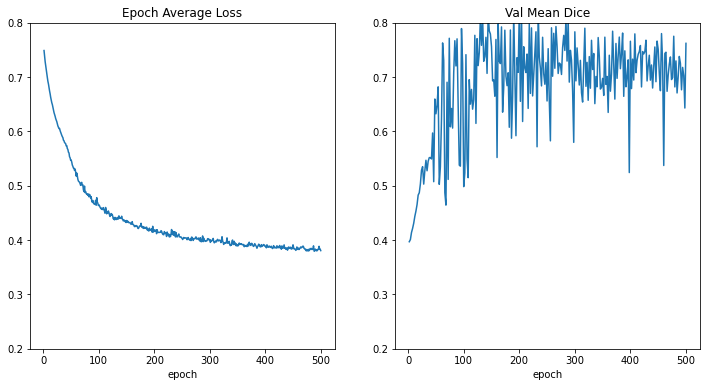

236s_iimage_1139765223418_CLEAN_ClassS_166-294.roi.nii.gz


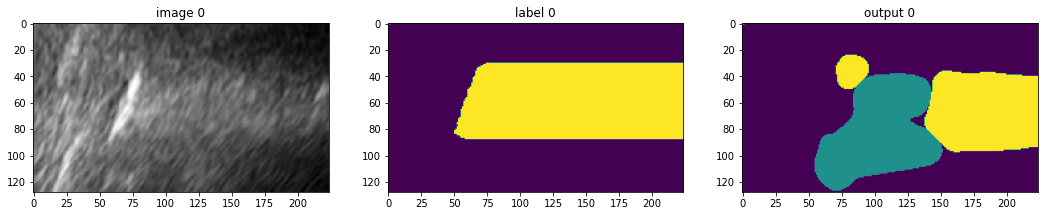

Number of not-sliding / sliding pixel = 256820 348911
    Min thresh = 1000
    Sliding


      FP ROI = 236s_iimage_1139765223418_CLEAN_ClassS_66-194.roi.nii.gz
236s_iimage_1139765223418_CLEAN_ClassS_66-194.roi.nii.gz


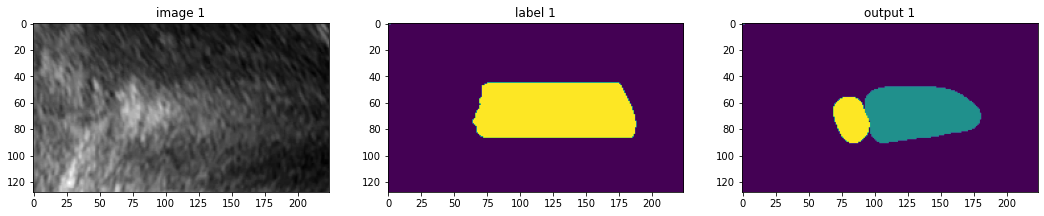

Number of not-sliding / sliding pixel = 169199 33392
    Min thresh = 1000
    Not Sliding


  Winner = Not Sliding
 FP Patient = 236s_iimage_1139765223418_CLEAN_ClassS_66-194.roi.nii.gz


236s_iimage_1327616672148_clean_ClassS_158-286.roi.nii.gz


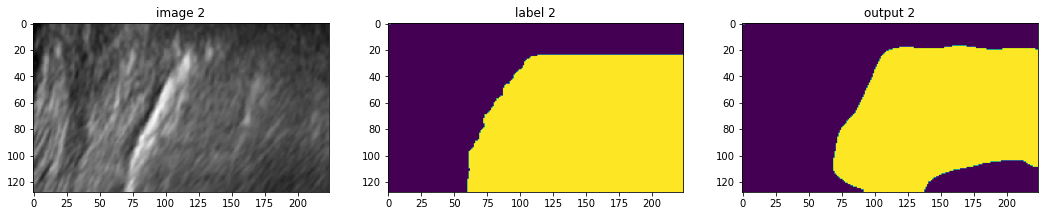

Number of not-sliding / sliding pixel = 0 799752
    Min thresh = 1000
    Sliding


  Winner = Sliding


      FP ROI = 237s_iimage_24164968068436_CLEAN_ClassS_172-300.roi.nii.gz
237s_iimage_24164968068436_CLEAN_ClassS_172-300.roi.nii.gz


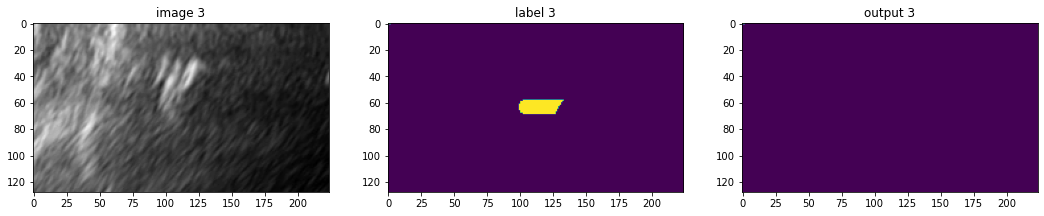

Number of not-sliding / sliding pixel = 0 0
    Min thresh = 1000
    Not Sliding


237s_iimage_24164968068436_CLEAN_ClassS_38-166.roi.nii.gz


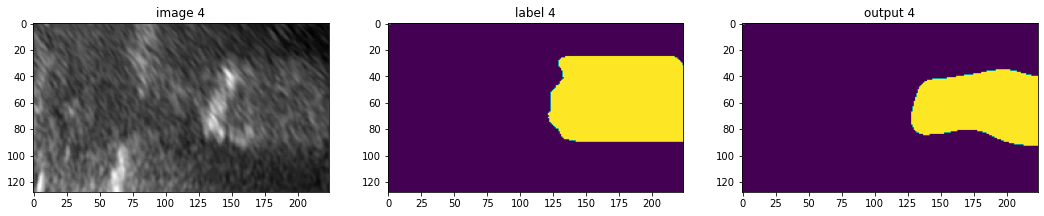

Number of not-sliding / sliding pixel = 0 267636
    Min thresh = 1000
    Sliding


  Winner = Not Sliding
 FP Patient = 237s_iimage_24164968068436_CLEAN_ClassS_38-166.roi.nii.gz


247ns_image_2734882394424_CLEAN_ClassN_83-211.roi.nii.gz


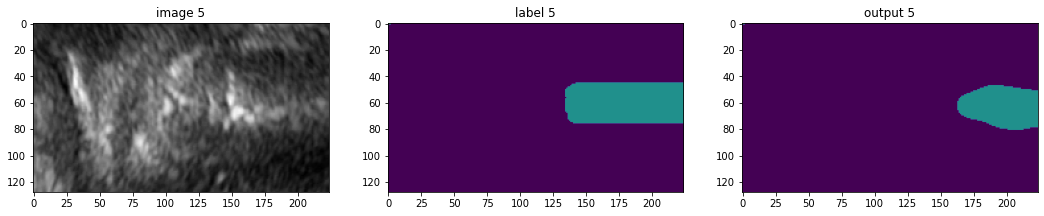

Number of not-sliding / sliding pixel = 99431 0
    Min thresh = 1000
    Not Sliding


  Winner = Not Sliding


247ns_image_2743083265515_CLEAN_ClassN_126-254.roi.nii.gz


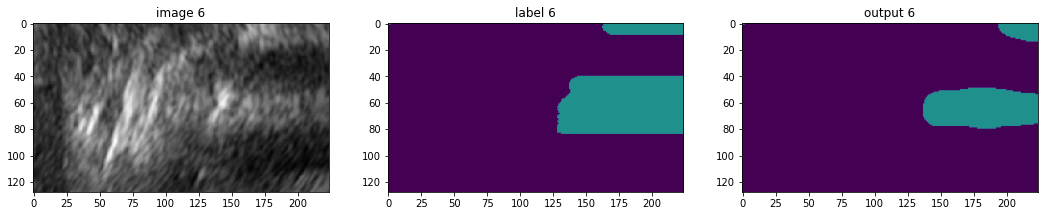

Number of not-sliding / sliding pixel = 170877 0
    Min thresh = 1000
    Not Sliding


247ns_image_2743083265515_CLEAN_ClassN_60-188.roi.nii.gz


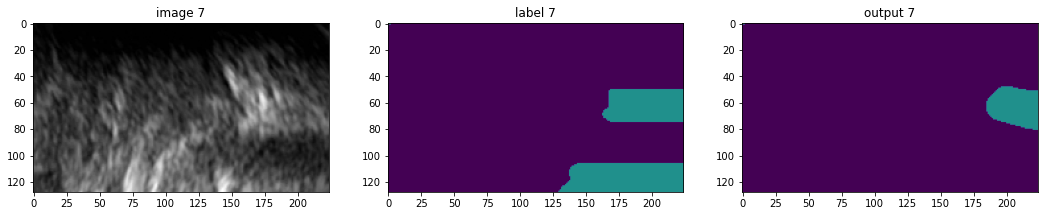

Number of not-sliding / sliding pixel = 70488 0
    Min thresh = 1000
    Not Sliding


  Winner = Not Sliding


   VFOLD = 1 of 15


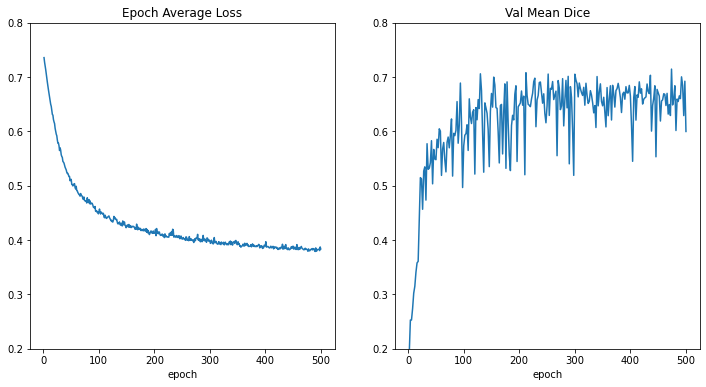

004s_iimage_73815992352100_clean_ClassS_178-306.roi.nii.gz


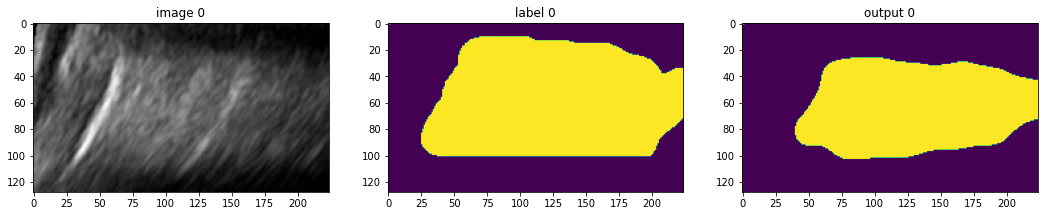

Number of not-sliding / sliding pixel = 2647 626564
    Min thresh = 1000
    Sliding


004s_iimage_73815992352100_clean_ClassS_70-198.roi.nii.gz


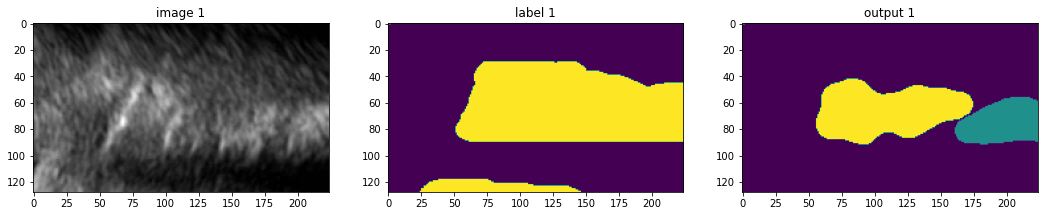

Number of not-sliding / sliding pixel = 120260 250123
    Min thresh = 1000
    Sliding


  Winner = Sliding


004s_iimage_74132233134844_clean_ClassS_0-128.roi.nii.gz


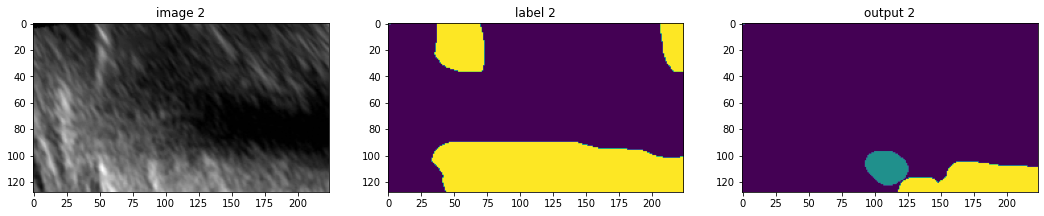

Number of not-sliding / sliding pixel = 62962 102490
    Min thresh = 1000
    Sliding


004s_iimage_74132233134844_clean_ClassS_192-320.roi.nii.gz


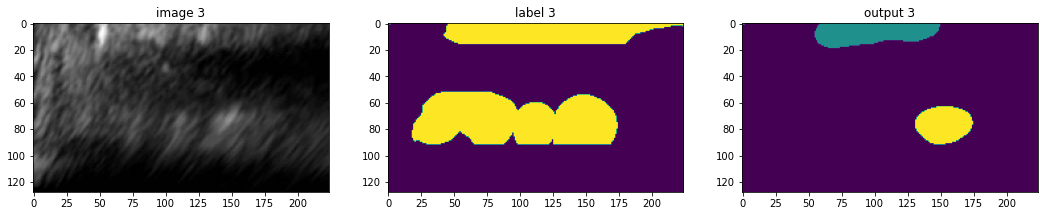

Number of not-sliding / sliding pixel = 72333 76052
    Min thresh = 1000
    Sliding


004s_iimage_74132233134844_clean_ClassS_85-213.roi.nii.gz


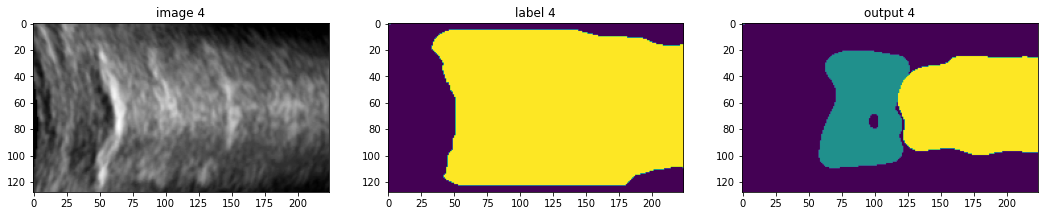

Number of not-sliding / sliding pixel = 264287 422349
    Min thresh = 1000
    Sliding


  Winner = Sliding


025ns_Image_262499828648_clean_ClassN_125-253.roi.nii.gz


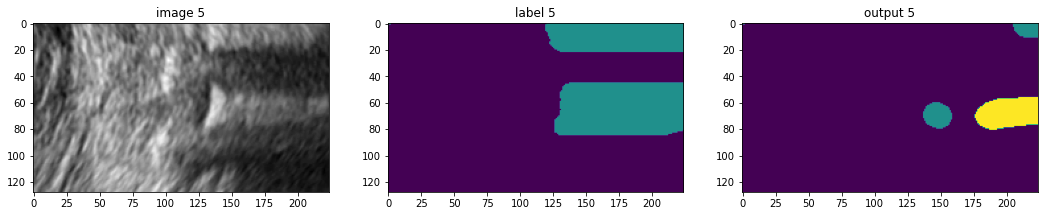

Number of not-sliding / sliding pixel = 69223 62895
    Min thresh = 1000
    Not Sliding


      FN ROI = 025ns_Image_262499828648_clean_ClassN_57-185.roi.nii.gz
025ns_Image_262499828648_clean_ClassN_57-185.roi.nii.gz


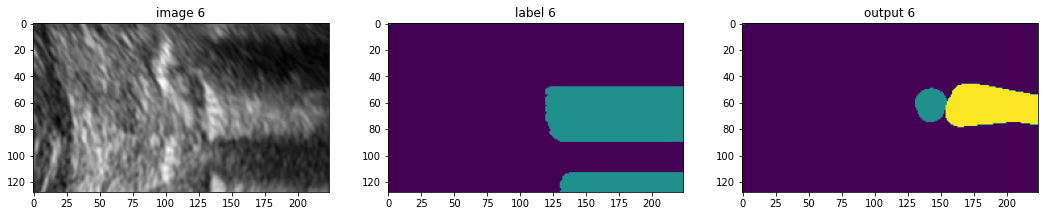

Number of not-sliding / sliding pixel = 72550 95203
    Min thresh = 1000
    Sliding


  Winner = Not Sliding


025ns_image_267456908021_clean_ClassN_0-128.roi.nii.gz


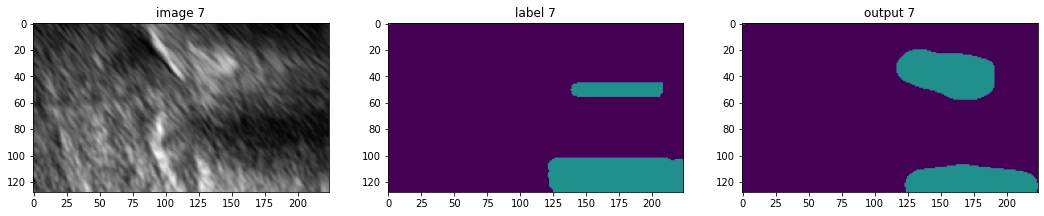

Number of not-sliding / sliding pixel = 215145 21042
    Min thresh = 1000
    Not Sliding


025ns_image_267456908021_clean_ClassN_131-259.roi.nii.gz


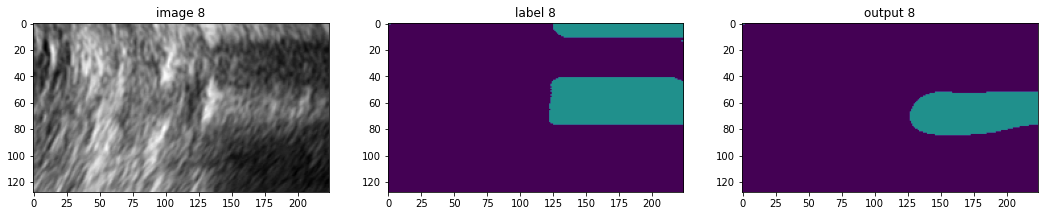

Number of not-sliding / sliding pixel = 172079 0
    Min thresh = 1000
    Not Sliding


025ns_image_267456908021_clean_ClassN_63-191.roi.nii.gz


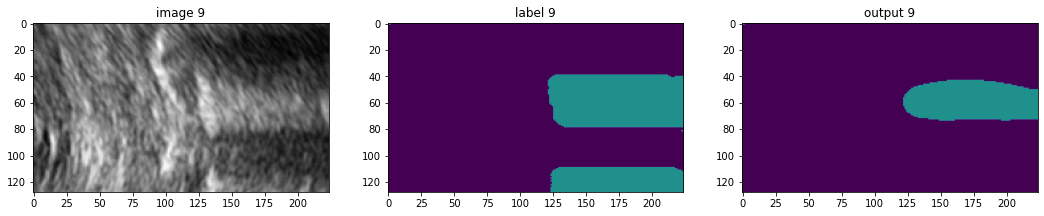

Number of not-sliding / sliding pixel = 175540 0
    Min thresh = 1000
    Not Sliding


  Winner = Not Sliding


   VFOLD = 2 of 15


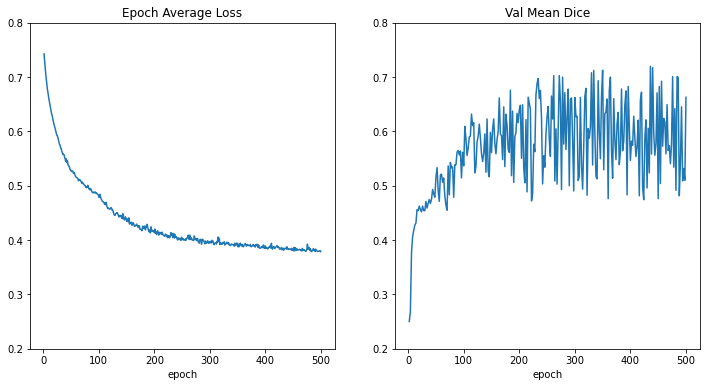

019s_iimage_10705997566592_CLEAN_ClassS_120-248.roi.nii.gz


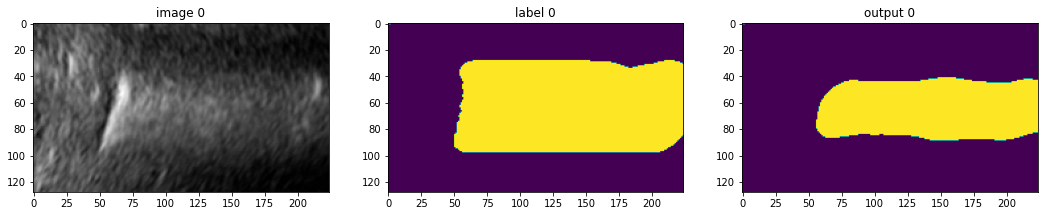

Number of not-sliding / sliding pixel = 0 407041
    Min thresh = 1000
    Sliding


      FP ROI = 019s_iimage_10705997566592_CLEAN_ClassS_27-155.roi.nii.gz
019s_iimage_10705997566592_CLEAN_ClassS_27-155.roi.nii.gz


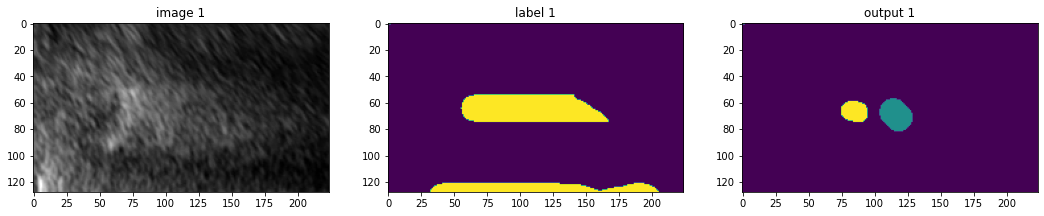

Number of not-sliding / sliding pixel = 30422 18820
    Min thresh = 1000
    Not Sliding


  Winner = Not Sliding
 FP Patient = 019s_iimage_10705997566592_CLEAN_ClassS_27-155.roi.nii.gz


019s_iimage_10891015221417_clean_ClassS_142-270.roi.nii.gz


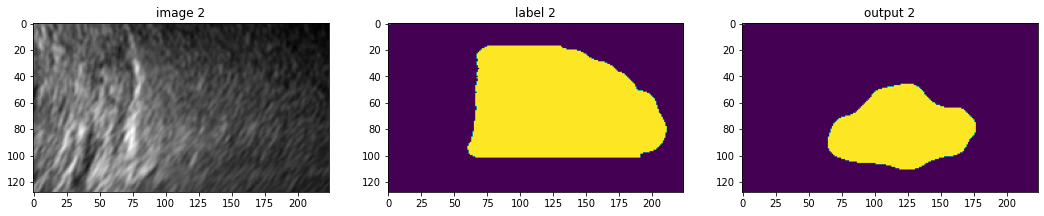

Number of not-sliding / sliding pixel = 0 333397
    Min thresh = 1000
    Sliding


  Winner = Sliding


026ns_image_1083297968960_clean_ClassN_148-276.roi.nii.gz


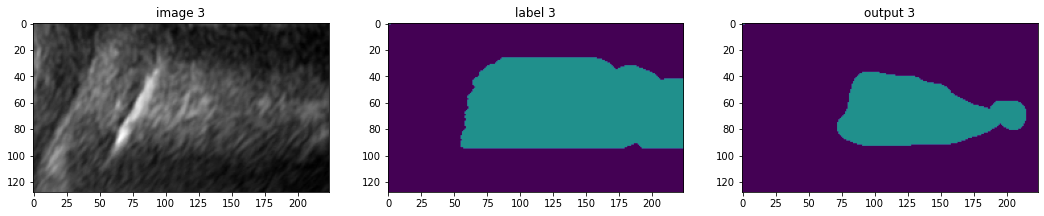

Number of not-sliding / sliding pixel = 317002 23734
    Min thresh = 1000
    Not Sliding


026ns_image_1083297968960_clean_ClassN_61-189.roi.nii.gz


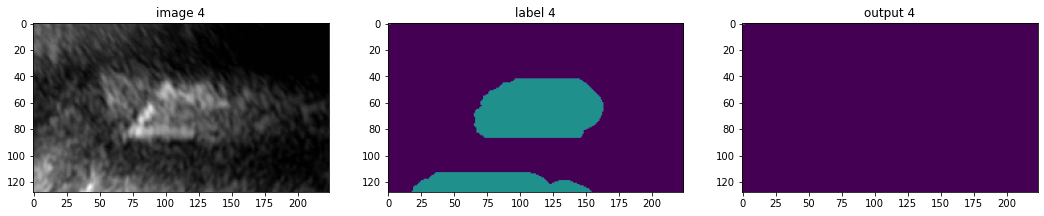

Number of not-sliding / sliding pixel = 0 0
    Min thresh = 1000
    Not Sliding


  Winner = Not Sliding


026ns_image_1087766719219_clean_ClassN_153-281.roi.nii.gz


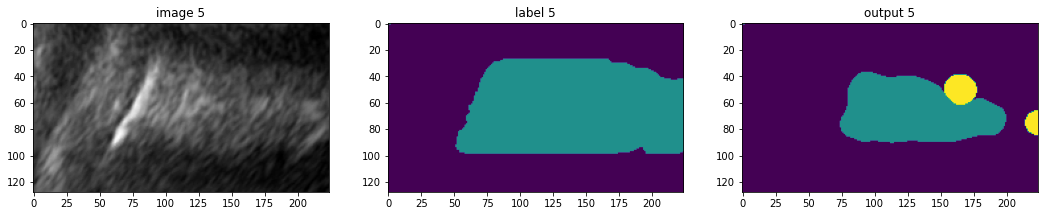

Number of not-sliding / sliding pixel = 322885 19481
    Min thresh = 1000
    Not Sliding


026ns_image_1087766719219_clean_ClassN_64-192.roi.nii.gz


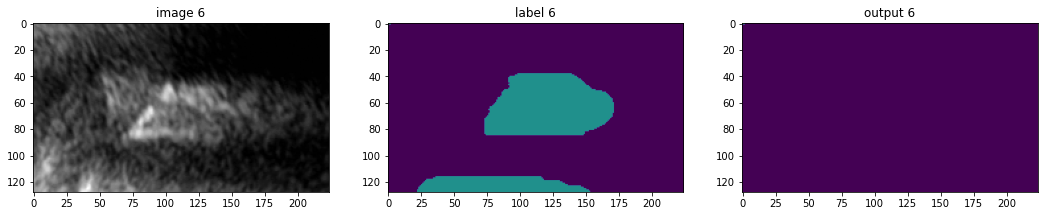

Number of not-sliding / sliding pixel = 0 0
    Min thresh = 1000
    Not Sliding


  Winner = Not Sliding


   VFOLD = 3 of 15


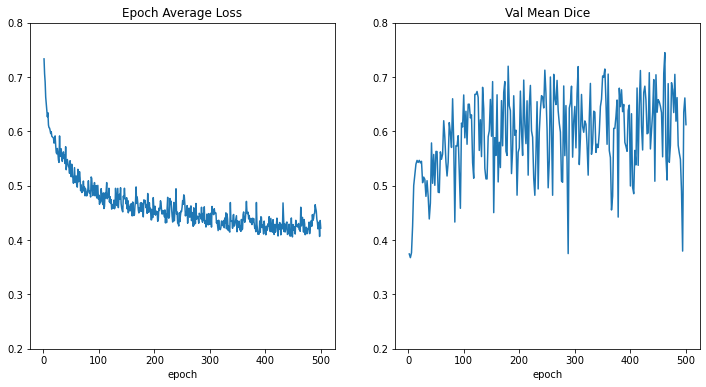

      FN ROI = 027ns_image_4641643404894_CLEAN_ClassN_154-282.roi.nii.gz
027ns_image_4641643404894_CLEAN_ClassN_154-282.roi.nii.gz


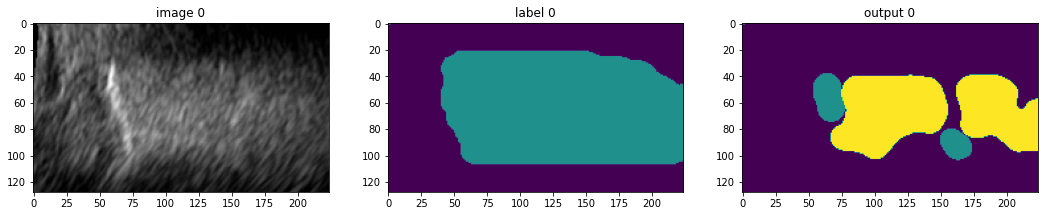

Number of not-sliding / sliding pixel = 42894 428892
    Min thresh = 1000
    Sliding


027ns_image_4641643404894_CLEAN_ClassN_21-149.roi.nii.gz


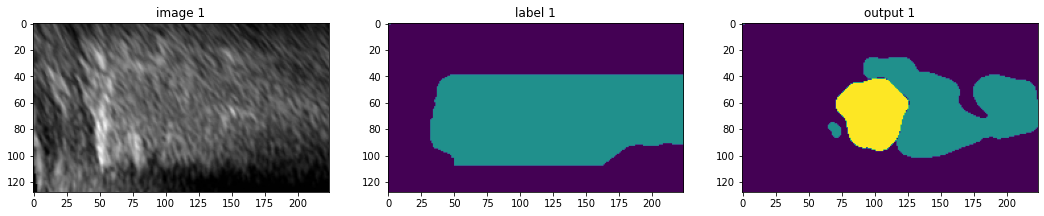

Number of not-sliding / sliding pixel = 267140 88273
    Min thresh = 1000
    Not Sliding


  Winner = Not Sliding


      FN ROI = 027ns_image_4743880599022_clean_ClassN_130-258.roi.nii.gz
027ns_image_4743880599022_clean_ClassN_130-258.roi.nii.gz


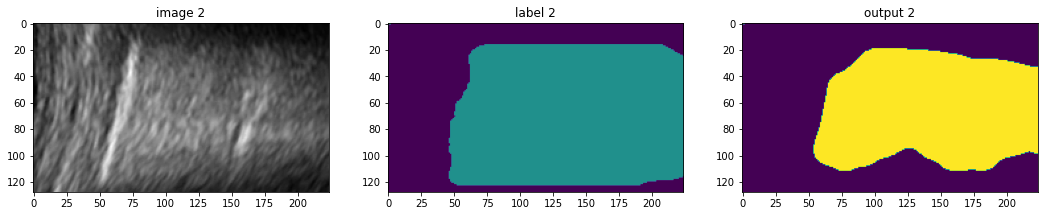

Number of not-sliding / sliding pixel = 18803 757874
    Min thresh = 1000
    Sliding


  Winner = Sliding
 FN Patient = 027ns_image_4743880599022_clean_ClassN_130-258.roi.nii.gz


030s_iimage_1180496934444_clean_ClassS_127-255.roi.nii.gz


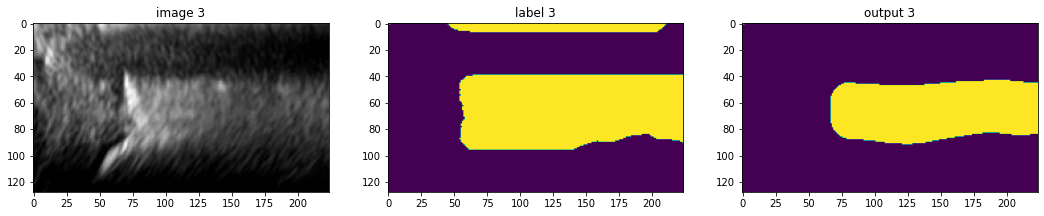

Number of not-sliding / sliding pixel = 0 387364
    Min thresh = 1000
    Sliding


030s_iimage_1180496934444_clean_ClassS_37-165.roi.nii.gz


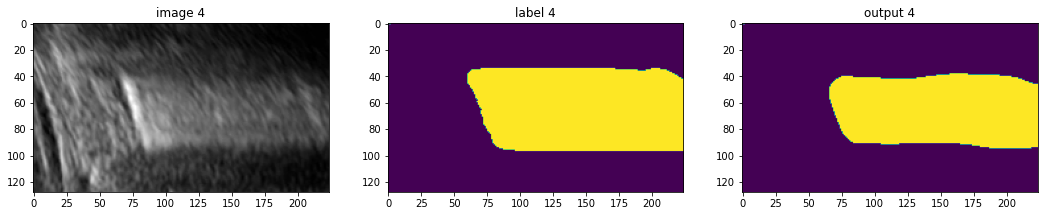

Number of not-sliding / sliding pixel = 0 473783
    Min thresh = 1000
    Sliding


  Winner = Sliding


030s_iimage_677741729740_clean_ClassS_122-250.roi.nii.gz


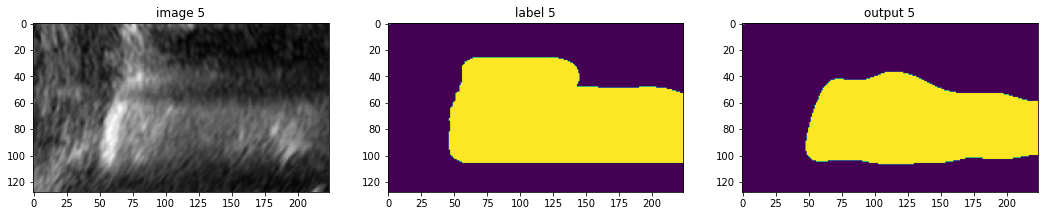

Number of not-sliding / sliding pixel = 0 601460
    Min thresh = 1000
    Sliding


  Winner = Sliding


   VFOLD = 4 of 15


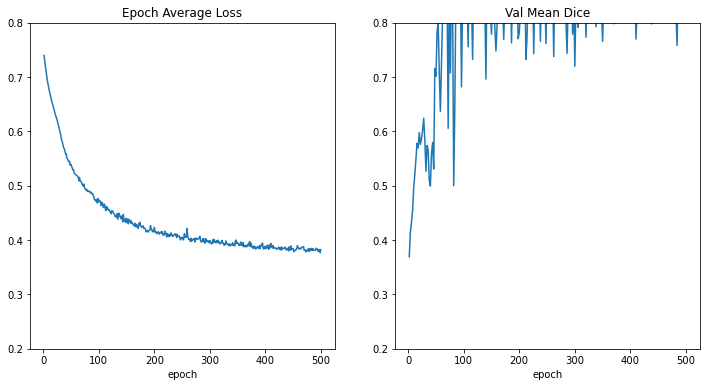

034s_iimage_3368391807672_clean_ClassS_102-230.roi.nii.gz


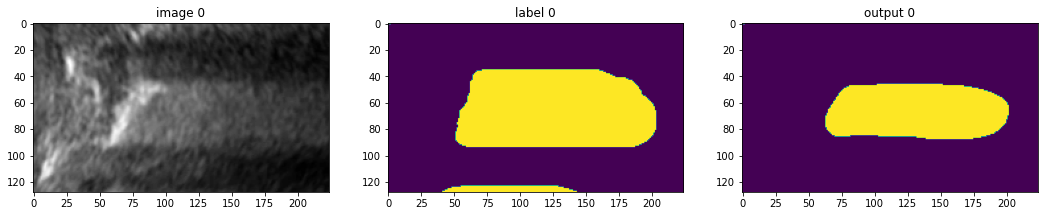

Number of not-sliding / sliding pixel = 0 311696
    Min thresh = 1000
    Sliding


034s_iimage_3368391807672_clean_ClassS_190-318.roi.nii.gz


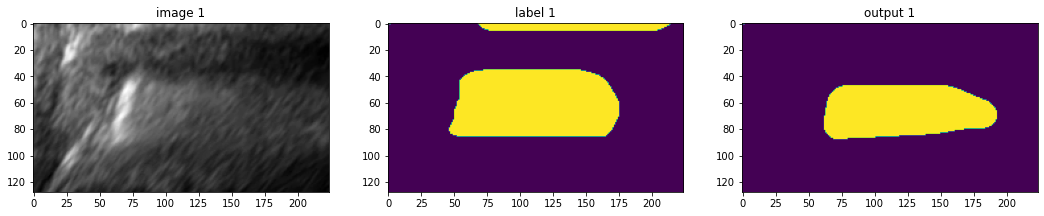

Number of not-sliding / sliding pixel = 0 267367
    Min thresh = 1000
    Sliding


034s_iimage_3368391807672_clean_ClassS_32-160.roi.nii.gz


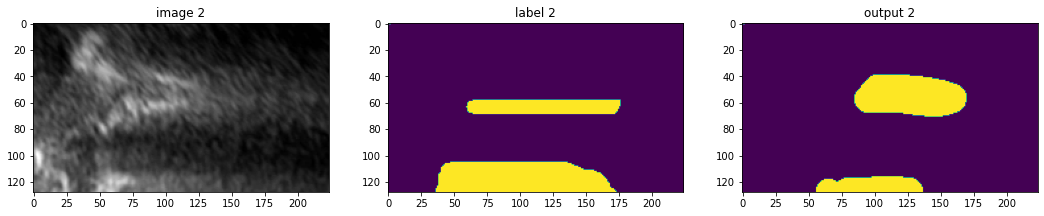

Number of not-sliding / sliding pixel = 0 184500
    Min thresh = 1000
    Sliding


  Winner = Sliding


034s_iimage_3401832241774_clean_ClassS_132-260.roi.nii.gz


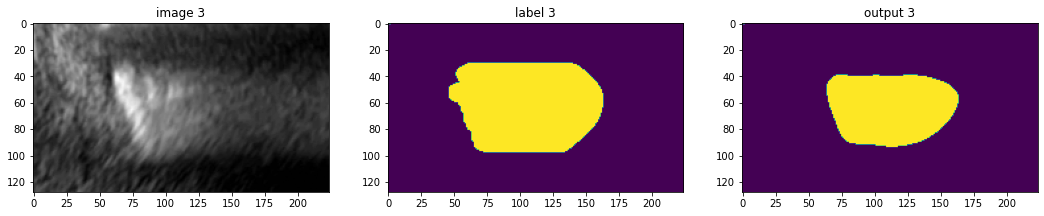

Number of not-sliding / sliding pixel = 0 274942
    Min thresh = 1000
    Sliding


034s_iimage_3401832241774_clean_ClassS_31-159.roi.nii.gz


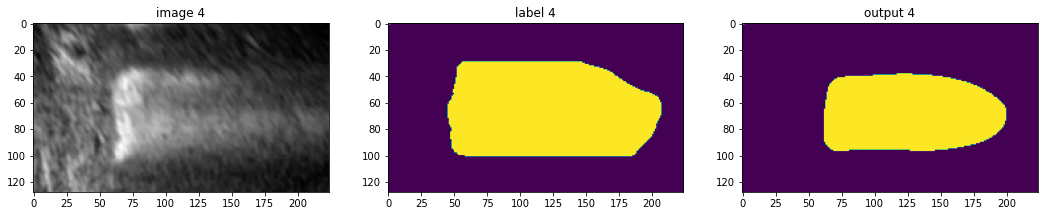

Number of not-sliding / sliding pixel = 0 424466
    Min thresh = 1000
    Sliding


  Winner = Sliding


035ns_image_1394469579519_clean_ClassN_11-139.roi.nii.gz


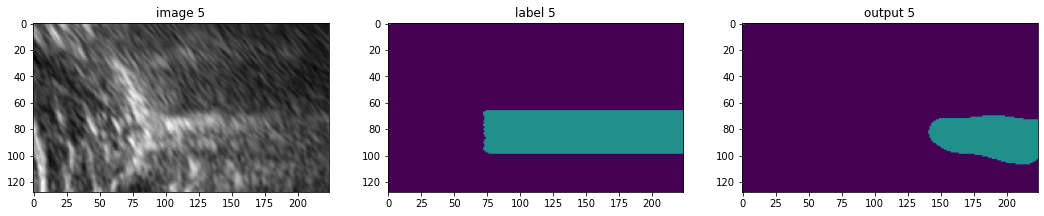

Number of not-sliding / sliding pixel = 146803 0
    Min thresh = 1000
    Not Sliding


035ns_image_1394469579519_clean_ClassN_130-258.roi.nii.gz


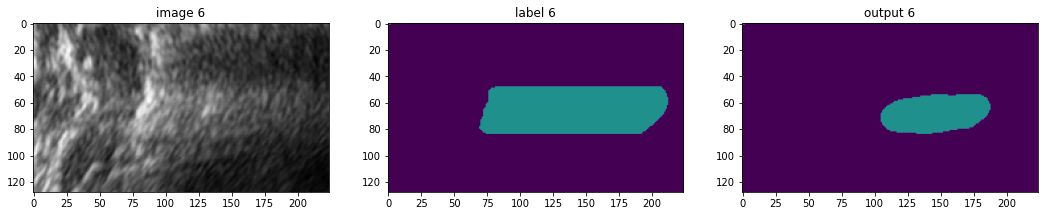

Number of not-sliding / sliding pixel = 117480 7321
    Min thresh = 1000
    Not Sliding


  Winner = Not Sliding


035ns_image_1404802450036_clean_ClassN_141-269.roi.nii.gz


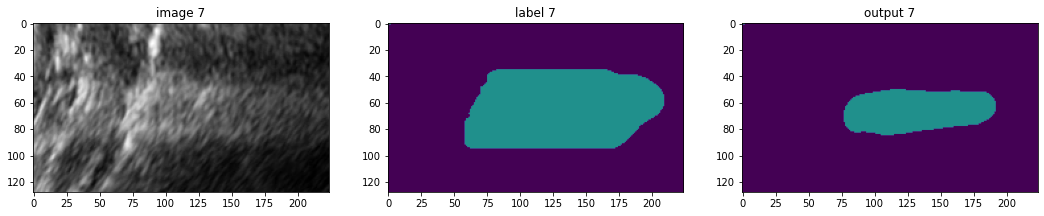

Number of not-sliding / sliding pixel = 168833 3300
    Min thresh = 1000
    Not Sliding


  Winner = Not Sliding


   VFOLD = 5 of 15


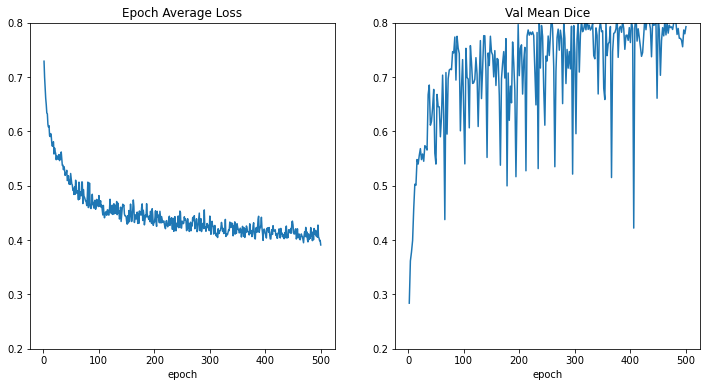

037s_iimage_588413346180_CLEAN_ClassS_178-306.roi.nii.gz


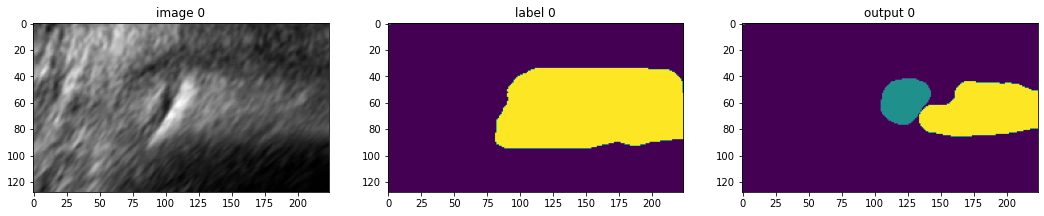

Number of not-sliding / sliding pixel = 50039 189220
    Min thresh = 1000
    Sliding


      FP ROI = 037s_iimage_588413346180_CLEAN_ClassS_69-197.roi.nii.gz
037s_iimage_588413346180_CLEAN_ClassS_69-197.roi.nii.gz


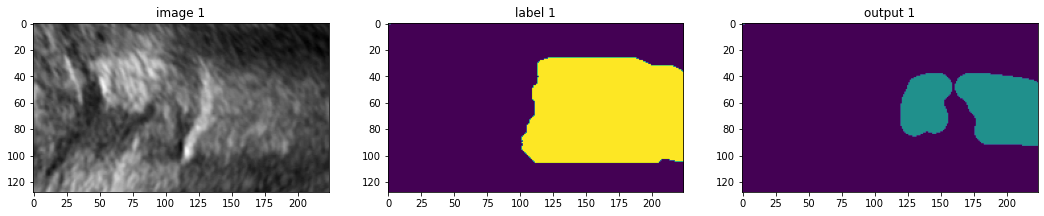

Number of not-sliding / sliding pixel = 259624 0
    Min thresh = 1000
    Not Sliding


  Winner = Not Sliding
 FP Patient = 037s_iimage_588413346180_CLEAN_ClassS_69-197.roi.nii.gz


      FN ROI = 048ns_image_1543571117118_clean_ClassN_188-316.roi.nii.gz
048ns_image_1543571117118_clean_ClassN_188-316.roi.nii.gz


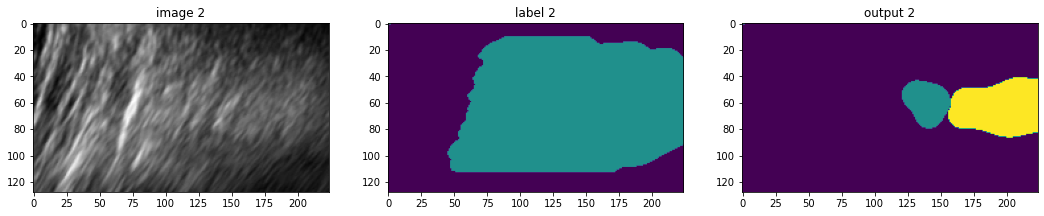

Number of not-sliding / sliding pixel = 43320 156675
    Min thresh = 1000
    Sliding


  Winner = Sliding
 FN Patient = 048ns_image_1543571117118_clean_ClassN_188-316.roi.nii.gz


048ns_image_1749559540112_clean_ClassN_192-320.roi.nii.gz


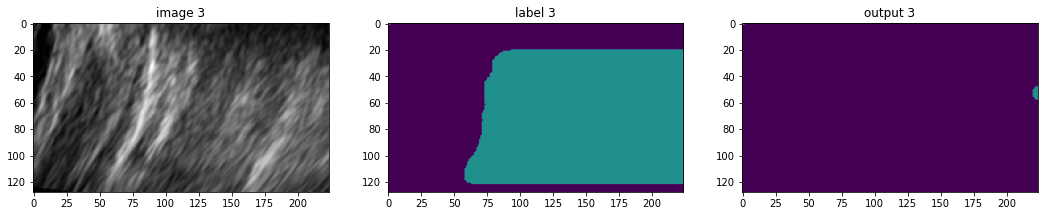

Number of not-sliding / sliding pixel = 28821 0
    Min thresh = 1000
    Not Sliding


  Winner = Not Sliding


   VFOLD = 6 of 15


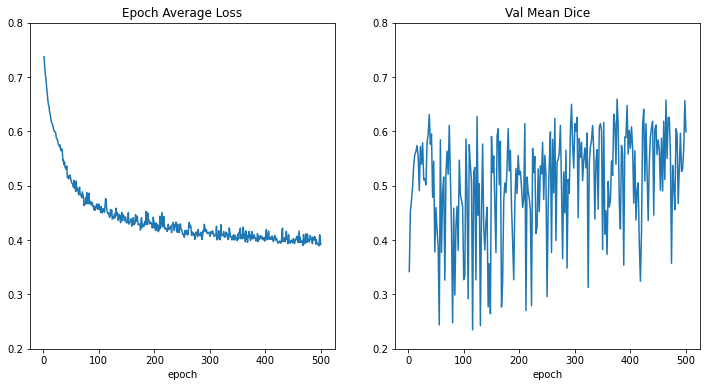

043s_iimage_10391571128899_CLEAN_ClassS_100-228.roi.nii.gz


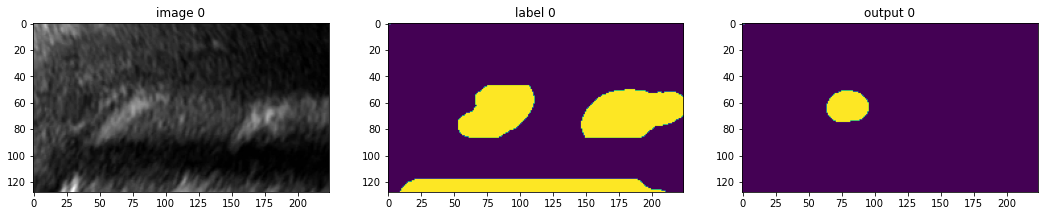

Number of not-sliding / sliding pixel = 0 28043
    Min thresh = 1000
    Sliding


043s_iimage_10391571128899_CLEAN_ClassS_185-313.roi.nii.gz


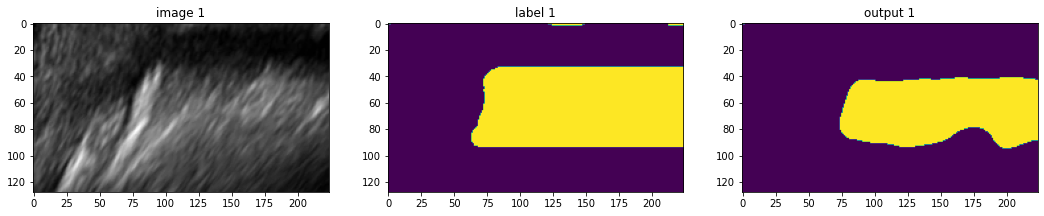

Number of not-sliding / sliding pixel = 0 416351
    Min thresh = 1000
    Sliding


  Winner = Sliding


043s_iimage_10395655826502_CLEAN_ClassS_189-317.roi.nii.gz


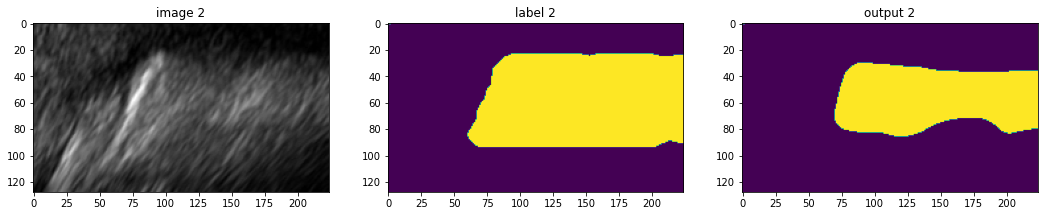

Number of not-sliding / sliding pixel = 0 419123
    Min thresh = 1000
    Sliding




In [ ]:
min_size = 1000
min_portion = 0.0

for prior in [[0.7,0.6,1.0]]: #[0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6]:
    print('*************')
    print("Prior =", prior)
    correct = 0
    incorrect = 0
    false_negatives = 0
    slice_correct = 0
    slice_incorrect = 0
    slice_false_negatives = 0
    for i in range(num_folds):
        (fcorrect, fincorrect, ffalse_negatives, fslice_correct, fslice_incorrect, fslice_false_negatives) = plot_vfold_training_curves(i, test_loader[i],
            min_size, min_portion, prior, True)
        correct += fcorrect
        incorrect += fincorrect
        false_negatives += ffalse_negatives
        slice_correct += fslice_correct
        slice_incorrect += fslice_incorrect
        slice_false_negatives += fslice_false_negatives
    print()
    print()
    print("Patients: Correct =", correct, "Incorrect =", incorrect, "Not Sliding as Sliding =", false_negatives)
    print("Slices: Correct =", slice_correct, "Incorrect = ", slice_incorrect, "Not Sliding as Sliding =", slice_false_negatives)
    print('*************')
